<a href="https://colab.research.google.com/github/RoyElkabetz/Tensor-Networks-Simple-Update/blob/main/Triangular_2d_lattice_BLBQ_Spin_1_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Tensor-Networks-Simple-Update
# add path to .py files for import
import sys
sys.path.insert(1, "/content/Tensor-Networks-Simple-Update/src")

Cloning into 'Tensor-Networks-Simple-Update'...
remote: Enumerating objects: 445, done.
remote: Counting objects: 100% (445/445), done.
remote: Compressing objects: 100% (369/369), done.
remote: Total 445 (delta 260), reused 162 (delta 71), pack-reused 0
Receiving objects: 100% (445/445), 1.14 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (260/260), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from TensorNetwork import TensorNetwork
import SimpleUpdate as su
import structure_matrix_generator as stmg
from tqdm.auto import tqdm


np.random.seed(216)

plt.rcParams.update({'font.size': 16, 
                     "figure.facecolor": 'white', 
                     "axes.facecolor": 'white', 
                     "savefig.facecolor": 'white', 
                     'savefig.edgecolor' : 'white', 
                     'figure.edgecolor' : 'white'})

# Spin-1 Simulation of a Bilinear-Biquadratic Heisenberg model on a triangular $2D$ lattice 

In [3]:
# The Tensor Network structure matrix
triangle_structure_matrix = stmg.infinite_structure_matrix_by_name('triangular')
print('The triangular 2D lattice structure matrix:')
print(triangle_structure_matrix)

The triangular 2D lattice structure matrix:
[[1 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 2 0 0 0 0 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 3 4 5 6 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 4 5 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 3 0 0 4 0 0 5 6 0 0 0]
 [0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 4 0 5 6 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 3 0 4 0 0 0 5 0 6]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 4 0 5 6]]


In [4]:
tri_tn = TensorNetwork(structure_matrix=triangle_structure_matrix, 
                       virtual_size=2)

In [7]:
# spin-1 operators
sx = np.array([[0., 1, 0],
               [1, 0, 1],
               [0, 1, 0]]) / np.sqrt(2)
sy = np.array([[0., -1j, 0],
               [1j, 0, -1j],
               [0, 1j, 0]]) / np.sqrt(2)
sz = np.array([[1., 0, 0],
               [0, 0, 0],
               [0, 0, -1]])

s_i = [sx, sy, sz]
s_j = [sx, sy, sz]
s_k = []

m_operator = np.sqrt(np.reshape(np.kron(sx, sx) + np.kron(sy, sy) + np.kron(sz, sz), (sx.shape[0], sx.shape[0], sx.shape[0], sx.shape[0])))

# get the spin-spin interaction term
interaction_term = np.zeros((np.power(sx.shape[0], 2), np.power(sx.shape[0], 2)), dtype=np.complex)
for s in s_i:
    interaction_term += np.kron(s, s)

# compute a list of hamiltonians for all angles
theta = np.linspace(0, 2 * np.pi, 100)
hamiltonian = []
for angle in theta:
    hamiltonian.append(np.cos(angle) * interaction_term + np.sin(angle) * np.power(interaction_term, 2))

The BLBQ Hamiltonian is given by

\begin{align}
    H = \cos{\left(\theta\right)}\sum_{<i, j>} \mathbf{S}_i\cdot \mathbf{S}_j + \sin{\left(\theta\right)}\sum_{<i, j>} \left(\mathbf{S}_i\cdot \mathbf{S}_j\right)^2
\end{align}

In [18]:
# Simple-Update parameters
d_max_tri = [2, 3, 4, 5, 6]
error = 1e-6
max_iterations = 200
tri_energy = {}
tri_magnetization_pair = {}
tri_magnetization = {}
j_ij = [-1.] * len(tri_tn.weights)
dts = [0.1, 0.01, 0.001, 0.0001, 0.00001]

# Run
for d_max in d_max_tri:
    tri_energy[d_max] = []
    tri_magnetization_pair[d_max] = []
    tri_magnetization[d_max] = []
    for i, angle in enumerate(theta):
        tri_tn = TensorNetwork(structure_matrix=triangle_structure_matrix, 
                          virtual_size=2, spin_dim=3)
        tri_su = su.SimpleUpdate(tensor_network=tri_tn, 
                                  dts=dts, 
                                  j_ij=j_ij, 
                                  h_k=0, 
                                  s_i=s_i, 
                                  s_j=s_j, 
                                  s_k=s_k, 
                                  d_max=d_max, 
                                  max_iterations=max_iterations, 
                                  convergence_error=error, 
                                  log_energy=False,
                                  print_process=False,
                                  hamiltonian=hamiltonian[i])
        tri_su.run()
        energy = tri_su.energy_per_site()
        magnetization_pair = 0
        magnetization = 0
        for ten, _ in enumerate(tri_tn.tensors):
            magn_x = np.power(tri_su.tensor_expectation(ten, sx), 2)
            magn_y = np.power(tri_su.tensor_expectation(ten, sy), 2)
            magn_z = np.power(tri_su.tensor_expectation(ten, sz), 2)
            magnetization += np.sqrt(np.real(magn_x + magn_y + magn_z))
        for edge, _ in enumerate(tri_tn.weights):
            magnetization_pair += np.real(np.sqrt(tri_su.tensor_pair_expectation(edge, m_operator)))
        magnetization_pair /= len(tri_tn.tensors)
        magnetization /= len(tri_tn.tensors)
        print('| D max: {:3d} | Theta: {:2.6f} | Energy: {:3.10f} | Magnetization pair: {:3.10f} | Magnetization: {:3.10f} |'
        .format(d_max, angle, energy, magnetization_pair, magnetization))
        tri_energy[d_max].append(energy)
        tri_magnetization_pair[d_max].append(magnetization_pair)
        tri_magnetization[d_max].append(magnetization)
    

| D max:   2 | Theta: 0.000000 | Energy: -3.0000000000 | Magnetization pair: 0.1999391012 | Magnetization: 0.0000000065 |
| D max:   2 | Theta: 0.063467 | Energy: -3.1373638798 | Magnetization pair: 0.1936725751 | Magnetization: 0.0000000011 |
| D max:   2 | Theta: 0.126933 | Energy: -3.2633095446 | Magnetization pair: 0.1883667134 | Magnetization: 0.0000000001 |
| D max:   2 | Theta: 0.190400 | Energy: -3.3771120660 | Magnetization pair: 0.1837813189 | Magnetization: 0.0000000000 |
| D max:   2 | Theta: 0.253866 | Energy: -3.4781540741 | Magnetization pair: 0.1797480888 | Magnetization: 0.0000000013 |
| D max:   2 | Theta: 0.317333 | Energy: -3.5659099728 | Magnetization pair: 0.1761453068 | Magnetization: 0.0000000032 |
| D max:   2 | Theta: 0.380799 | Energy: -3.6399363363 | Magnetization pair: 0.1728824725 | Magnetization: 0.0000000001 |
| D max:   2 | Theta: 0.444266 | Energy: -3.6998659454 | Magnetization pair: 0.1698905925 | Magnetization: 0.0000000000 |
| D max:   2 | Theta: 0.

KeyboardInterrupt: ignored

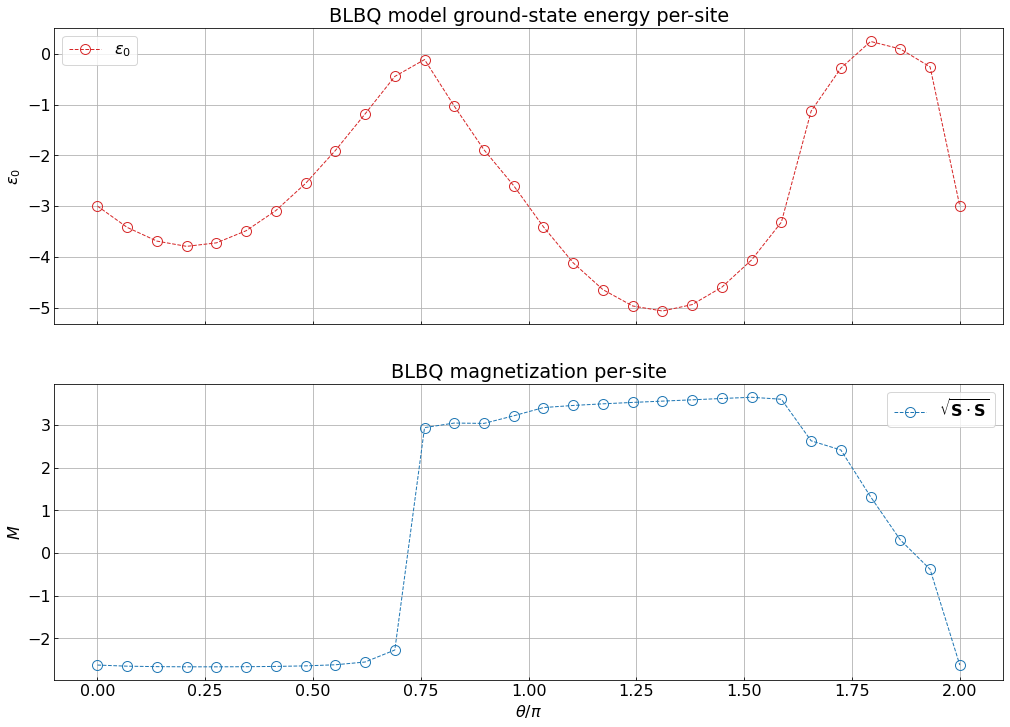

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(17, 12))
ax[0].plot(theta / np.pi, tri_energy, '--o', label=r'$\epsilon_0$', color='tab:red', 
           markerfacecolor='none', linewidth=1, markersize=10)
ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[0].set_ylabel(r'$\epsilon_0$')
ax[0].set_title('BLBQ model ground-state energy per-site')
ax[0].tick_params(direction='in', axis='both')
ax[0].grid()
ax[0].legend()

ax[1].plot(theta / np.pi, tri_magnetization, '--o', label=r'$\sqrt{\mathbf{S}\cdot\mathbf{S}}$', 
           color='tab:blue', markerfacecolor='none', linewidth=1, markersize=10)
ax[1].set_xlabel(r'$\theta / \pi$')
ax[1].set_ylabel(r'$M$')
ax[1].set_title(r'BLBQ magnetization per-site')
ax[1].tick_params(direction='in', axis='both')
ax[1].grid()
ax[1].legend()

In [14]:
sx+sy+sz

array([[ 1.        +0.j        ,  0.70710678-0.70710678j,
         0.        +0.j        ],
       [ 0.70710678+0.70710678j,  0.        +0.j        ,
         0.70710678-0.70710678j],
       [ 0.        +0.j        ,  0.70710678+0.70710678j,
        -1.        +0.j        ]])

In [15]:
m_operator

array([[[[1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j, 0.+0.j],
         [1.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j, 0.+1.j],
         [0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]]],


       [[[0.+0.j, 1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j, 1.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j],
         [1.+0.j, 0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j]]],


       [[[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j, 0.+0.j],
         [0.+1.j, 0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 1.+0.j]]]])